In [324]:
from sklearn.model_selection import train_test_split
def extract_full_sentences(file_path,test_size = None,shuffle = None):
    random_state = 42
    X = []
    y = []
    temp_X = []
    temp_y = []
    with open(file_path, 'r', encoding="utf8") as fin :
        for l in fin :
            l = l.rstrip().split("\t")
            if l != [""]:
                temp_X.append(l[1].lower())
                temp_y.append(l[7])
            else :
                X.append(temp_X)
                temp_X = []
                y.append(temp_y)
                temp_y = []
    if test_size is not None:
        X, X_val, y, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=shuffle)
        return X, X_val, y, y_val

    else :
        return X,y

In [322]:
import torch

class SstDataset(torch.utils.data.Dataset):
    def __init__(self, encodings,labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

https://github.com/soutsios/pos-tagger-bert/blob/master/pos_tagger_bert.ipynb

In [279]:
X_train, X_val, y_train, y_val = extract_full_sentences('../dimsum-data-1.5/dimsum16.train',0.15,True)
print(X_train[0])
print(y_train[0])

['the', 'night', 'that', 'jam', 'master', "jay's", 'hand', 'slipped', '!', 'analysis', 'by', 'cosmo', 'baker', ':', 'url']
['', 'n.time', '', 'n.body', '', '', '', 'v.motion', '', 'n.act', '', 'n.person', '', '', '']


In [280]:
tags = set([item for sublist in y_train for item in sublist])
print('TOTAL TAGS: ', len(tags))

TOTAL TAGS:  42


In [281]:
tag2int = {}
int2tag = {}

for i, tag in enumerate(sorted(tags)):
    tag2int[tag] = i
    int2tag[i] = tag

In [282]:
def map_tagging(y):
    temp_y = []
    for sentence in y :
        temp_y.append([tag2int[tag] for tag in sentence])
    return temp_y

In [283]:
y_train = map_tagging(y_train)
y_val = map_tagging(y_val)

In [284]:
MAX_SEQUENCE_LENGTH = 70
EPOCHS = 30

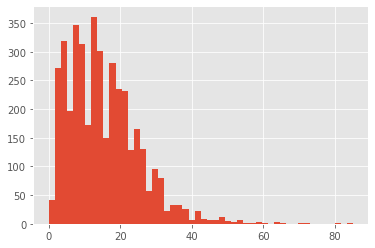

In [285]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.hist([len(s) for s in X_train], bins=50)
plt.show()

In [286]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at C:\Users\eliea/.cache\huggingface\transformers\23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.15.0",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at C:\Users\eliea/.cache\huggingface\transformers\0e1bbfda7f6

In [288]:
def tokenize_and_align_labels(X,y):
    tokenized_inputs = tokenizer(X, padding=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(y):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])

        labels.append(label_ids)

    return tokenized_inputs, labels

In [289]:
tokenized_train, padded_label_train = tokenize_and_align_labels(X_train,y_train)
tokenized_val, padded_label_val = tokenize_and_align_labels(X_val,y_val)

In [290]:
train_dataset = SstDataset(tokenized_train,padded_label_train)
val_dataset = SstDataset(tokenized_val,padded_label_val)

In [291]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

In [292]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

model = AutoModelForTokenClassification.from_pretrained("distilbert-base-uncased", num_labels=len(tags))

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at C:\Users\eliea/.cache\huggingface\transformers\23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LAB

In [293]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [294]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [295]:
trainer.train()

***** Running training *****
  Num examples = 4084
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 768
C:\Users\eliea\anaconda3\envs\dataoutai\lib\site-packages\transformers\data\data_collator.py:317: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence_length = torch.tensor(batch["input_ids"]).shape[1]
C:\Users\eliea\anaconda3\envs\dataoutai\lib\site-packages\transformers\data\data_collator.py:328: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}


Epoch,Training Loss,Validation Loss


***** Running Evaluation *****
  Num examples = 721
  Batch size = 16
Saving model checkpoint to ./results\checkpoint-500
Configuration saved in ./results\checkpoint-500\config.json
Model weights saved in ./results\checkpoint-500\pytorch_model.bin
tokenizer config file saved in ./results\checkpoint-500\tokenizer_config.json
Special tokens file saved in ./results\checkpoint-500\special_tokens_map.json
C:\Users\eliea\anaconda3\envs\dataoutai\lib\site-packages\transformers\data\data_collator.py:317: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence_length = torch.tensor(batch["input_ids"]).shape[1]
C:\Users\eliea\anaconda3\envs\dataoutai\lib\site-packages\transformers\data\data_collator.py:328: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires

TrainOutput(global_step=768, training_loss=0.6807648042837778, metrics={'train_runtime': 154.1681, 'train_samples_per_second': 79.472, 'train_steps_per_second': 4.982, 'total_flos': 284716166625072.0, 'train_loss': 0.6807648042837778, 'epoch': 3.0})

In [345]:
from transformers import pipeline

nerpipeline = pipeline('ner', model=model, tokenizer=tokenizer, device = 0)
text = "flutes sound really bad with cheap mics"
pred = nerpipeline(text)

In [348]:
for token in pred :
    word = token['word']
    pred_sst = int2tag[int(token['entity'].split("_")[1])]
    print(f"{word}", end ="")
    if pred_sst != "":
        print(f" : {pred_sst}")
    else :
        print()

flutes : n.artifact
sound : v.cognition
really
bad
with
cheap
mic : n.artifact
##s : n.artifact


In [354]:
def decode_pred(pred):
    y = []
    for token in pred :
        if token['word'].startswith("##"):
            continue
        pred_sst = int2tag[int(token['entity'].split("_")[1])]
        y.append(pred_sst)

    return y

In [355]:
print(decode_pred(pred))

['n.artifact', 'v.cognition', '', '', '', '', 'n.artifact']


In [356]:
X_test, y_test = extract_full_sentences('../dimsum-data-1.5/dimsum16.test')
y_pred = []
for sentence in X_test :
    pred = decode_pred(nerpipeline(' '.join(sentence)))
    y_pred.append(pred)

In [357]:
for sentence, pred, gold in zip(X_test,y_pred,y_test):
    for word, pred_tag, gold_tag in zip(sentence, pred, gold):
        print(f"{word}", end ="")
        if pred_tag != "" or gold_tag != "" :
            print(f" |pred :{pred_tag}|gold :{gold_tag} ")
        else :
            print()

@jojolyrics
i
hear |pred :|gold :v.perception 
enough |pred :v.communication|gold : 
talking |pred :|gold :v.communication 
, |pred :v.communication|gold : 
just
turn |pred :|gold :v.motion 
round |pred :v.motion|gold : 
keep |pred :|gold :v.stative 
walking |pred :v.stative|gold :v.motion 
haha |pred :v.motion|gold : 
in
that
part |pred :|gold :n.location 
photo |pred :n.artifact|gold :n.artifact 
:
http://t.co/2zggp2a
ahh
.
flutes |pred :n.artifact|gold :n.artifact 
sound |pred :v.cognition|gold :v.perception 
really
bad
with
cheap
mics |pred :n.artifact|gold :n.artifact 
.
writing |pred :v.communication|gold :v.creation 
a
song |pred :n.communication|gold :n.communication 
now
,
just
need |pred :v.cognition|gold :v.stative 
chords |pred :n.communication|gold :n.relation 
and
i'll |pred :|gold :v.stative 
be
good
. |pred :v.stative|gold : 
bye
:d
we
called |pred :v.communication|gold :v.communication 
the
number |pred :n.communication|gold :n.attribute 
which
promised |pred :v.commun